### Morph a 2D lattice via gradient descent

In [ ]:
import matplotlib.pyplot as plt
%matplotlib notebook
from matplotlib.animation import FuncAnimation

import numpy as np
import seaborn as sns

from LattyMorph.morphing import create_flat_2D_sheet
from LattyMorph.morphing.lattice_models import Toti2D

from tqdm import trange
import torch

Create first target config

Legit config.!


<IPython.core.display.Javascript object>


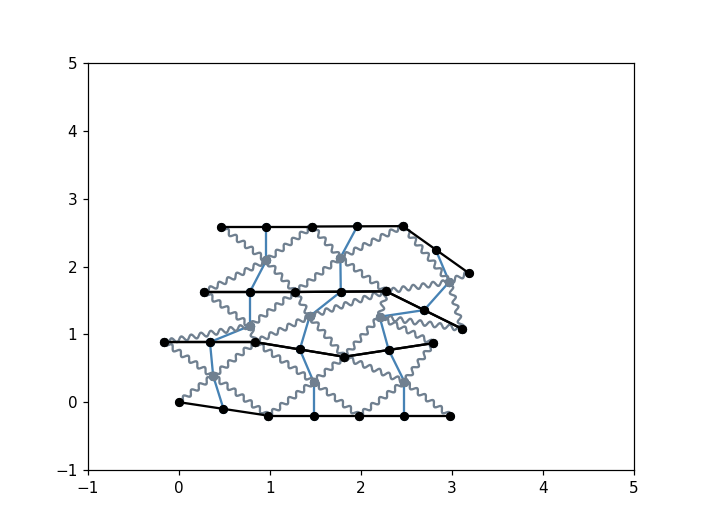

<Axes: >

In [2]:
model_tgt = create_flat_2D_sheet(3,3)
build = model_tgt.forward()
if build == True:
    print('Legit config.!')

model_tgt.config[0][0]['phi'].data[0] = -0.2
model_tgt.config[1][0]['phiPrime'].data[0] = 0.
model_tgt.config[0][0]['theta'].data[0] = 2
model_tgt.config[0][0]['thetaPrime'].data[0] = 1.5
model_tgt.config[1][0]['theta'].data[0] = 1.55
model_tgt.config[-1][0]['theta'].data[0] = 1.2
model_tgt.config[-2][0]['theta'].data[0] = 0.5
model_tgt.forward()
model_tgt.plot((-1,5), (-1,5))

Create second target config

Legit config.!


<IPython.core.display.Javascript object>


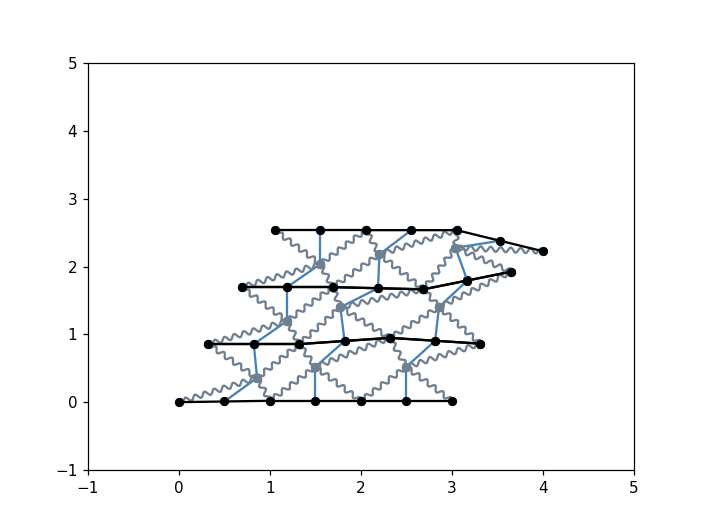

<Axes: >

In [3]:
model_tgt2 = create_flat_2D_sheet(3,3)
build = model_tgt2.forward()
if build == True:
    print('Legit config.!')

model_tgt2.config[0][0]['phi'].data[0] = 0.02
model_tgt2.config[1][0]['phiPrime'].data[0] = 0.
model_tgt2.config[0][0]['theta'].data[0] = 1.5
model_tgt2.config[0][0]['thetaPrime'].data[0] = 1.5
model_tgt2.config[2][0]['theta'].data[0] = .75
model_tgt2.config[-2][0]['theta'].data[0] = .75
model_tgt2.config[-3][0]['theta'].data[0] = .75
model_tgt2.forward()
model_tgt2.plot((-1,5), (-1,5))

Create our lattice initially configured to be flat

<IPython.core.display.Javascript object>


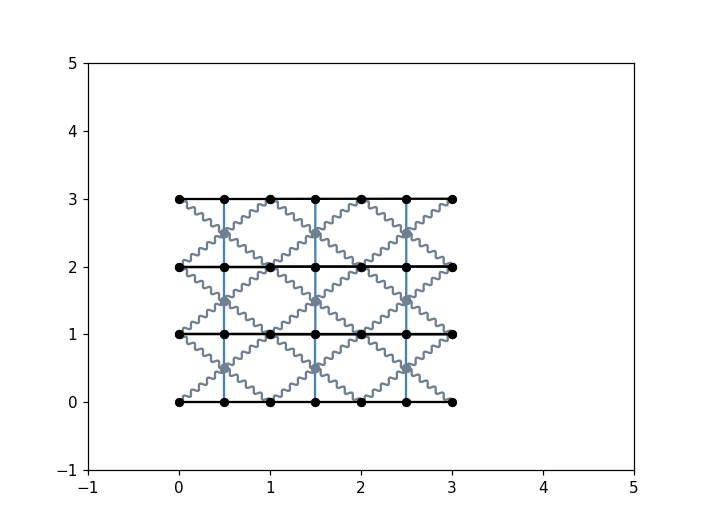

<Axes: >

In [4]:
model = create_flat_2D_sheet(3,3)
# Point of origin (i.e., moving the lattice around) should not be possible 
# during training. Thus, set requires_grad to False for this parameter.
model.origin.requires_grad = False
model.forward()
model.plot((-1,5), (-1,5))

Define the loss functions (here: point-wise overlap)

In [5]:
def calc_loss(model, model_tgt):
    lossf = torch.nn.MSELoss()
    loss = 0
    for i in range(model.shape[0]):
        for j in range(model.shape[1]):
            loss += lossf(model.lattice[i][j].pointB, model_tgt.lattice[i][j].pointB.detach())
            loss += lossf(model.lattice[i][j].pointC, model_tgt.lattice[i][j].pointC.detach())
            loss += lossf(model.lattice[i][j].pointAprime, model_tgt.lattice[i][j].pointAprime.detach())
            loss += lossf(model.lattice[i][j].pointBprime, model_tgt.lattice[i][j].pointBprime.detach())
    return loss

Reconfigure to the first target first!

In [6]:
configs = []
configs.append(model.lattice_config())
steps = 1200

pbar = trange(steps)
for i in pbar:
    if i%100 == 0:
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    optimizer.zero_grad()
    valid = model.forward()
    if valid == False:
        print("Yikes!")
        break
    loss = calc_loss(model, model_tgt)
    loss.backward()
    optimizer.step()
    pbar.set_description('Loss: {:.5f}'.format(loss.detach()))
    configs.append(model.lattice_config())

Loss: 0.00120: 100%|████████████████████████████████████████████████████████████████| 1200/1200 [00:18<00:00, 64.31it/s]


Then reconfigure to the second target!

In [8]:
steps = 1200

pbar = trange(steps)
for i in pbar:
    if i%100 == 0:
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    optimizer.zero_grad()
    valid = model.forward()
    if valid == False:
        print("Yikes!")
        break
    loss = calc_loss(model, model_tgt2)
    loss.backward()
    optimizer.step()
    pbar.set_description('Loss: {:.5f}'.format(loss.detach()))
    configs.append(model.lattice_config())

Loss: 0.00014: 100%|████████████████████████████████████████████████████████████████| 1200/1200 [00:17<00:00, 67.10it/s]


Animate!

<IPython.core.display.Javascript object>


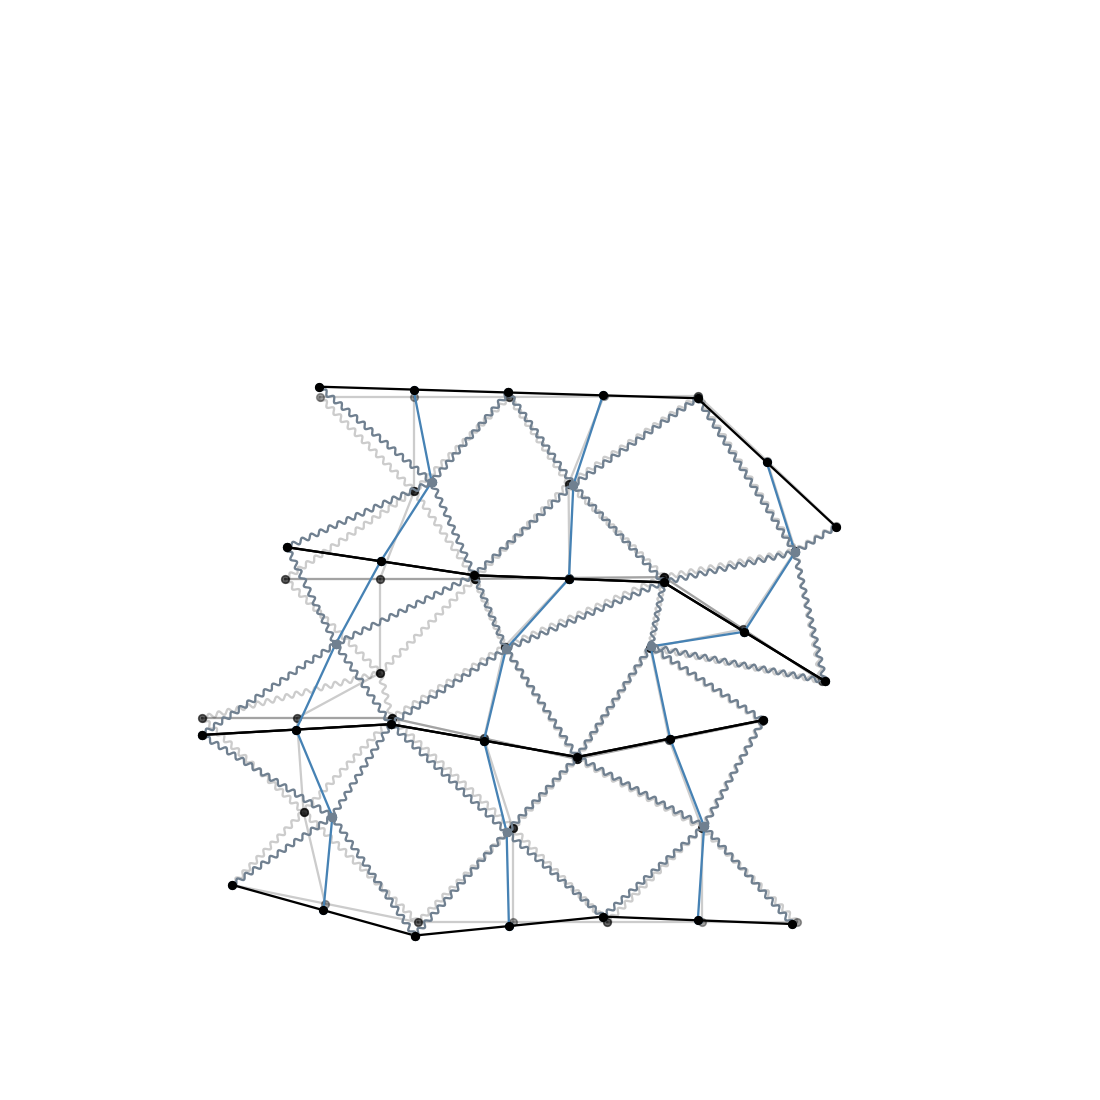

In [9]:
plt.rcParams['figure.dpi'] = 100

fig, ax = plt.subplots(1,1, figsize=(10,10))
sns.despine(fig=fig, bottom=True,top=True,left=True,right=True)
ln, = ax.plot([0], [0])
ax.set_xticks([])
ax.set_yticks([])

def init():
    return ln,

def update(kk):
    ax.clear()
    with torch.no_grad():
        if kk < 1200:
            model_tgt.plot(ax=ax, xlim=(-0.5,4), ylim=(-0.5,4), alpha = 0.2)
        else:
            model_tgt2.plot(ax=ax, xlim=(-0.5,4), ylim=(-0.5,4), alpha = 0.2)
        model_plt = Toti2D(configs[kk][0])
        model_plt.forward()
        model_plt.plot(ax=ax, xlim=(-0.5,4), ylim=(-0.5,4))
        ax.set_xticks([])
        ax.set_yticks([])

ani = FuncAnimation(fig, update, frames=np.arange(0,2401,40),
                    init_func=init, blit=True)

# ani.save('Totimorphing_2D_2Shapes.gif')